In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D,  Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow_datasets as tfds
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 2.5 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.4
    Uninstalling typeguard-4.4.4:
      Successfully uninstalled typeguard-4.4.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


Streaming output truncated to the last 5000 lines.
  inflating: /content/oxford-iiit-pet/training_set/training_set/cats/cat.3704.jpg  
  inflating: /content/oxford-iiit-pet/training_set/training_set/cats/cat.3705.jpg  
  inflating: /content/oxford-iiit-pet/training_set/training_set/cats/cat.3706.jpg  
  inflating: /content/oxford-iiit-pet/training_set/training_set/cats/cat.3707.jpg  
  inflating: /content/oxford-iiit-pet/training_set/training_set/cats/cat.3708.jpg  
  inflating: /content/oxford-iiit-pet/training_set/training_set/cats/cat.3709.jpg  
  inflating: /content/oxford-iiit-pet/training_set/training_set/cats/cat.371.jpg  
  inflating: /content/oxford-iiit-pet/training_set/training_set/cats/cat.3710.jpg  
  inflating: /content/oxford-iiit-pet/training_set/training_set/cats/cat.3711.jpg  
  inflating: /content/oxford-iiit-pet/training_set/training_set/cats/cat.3712.jpg  
  inflating: /content/oxford-iiit-pet/training_set/training_set/cats/cat.3713.jpg  
  inflating: /content/oxfo

In [ ]:
def load_image(datapoint):
    image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0

    mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE), method='nearest')
    mask = tf.cast(mask, tf.int32) - 1
    mask = tf.clip_by_value(mask, 0, NUM_CLASSES - 1)
    mask = tf.squeeze(mask, axis=-1)
    return image, mask

In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    titles = ['Input Image', 'True Mask', 'Predicted Mask']
    for i, img in enumerate(display_list):
        plt.subplot(1, len(display_list), i+1)
        plt.title(titles[i])
        img = tf.squeeze(img)
        arr = img.numpy() if isinstance(img, tf.Tensor) else img
        if arr.ndim == 2:
            plt.imshow(arr, cmap='gray', vmin=0, vmax=NUM_CLASSES-1)
        else:
            plt.imshow(arr)
        plt.axis('off')
    plt.show()

In [ ]:
def unet_model(input_size=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES):
    base_model = ResNet50(input_shape=input_size, include_top=False, weights='imagenet')
    layer_names = [
        'conv1_relu',        
        'conv2_block3_out', 
        'conv3_block4_out',  
        'conv4_block6_out',  
    ]
    layers = [base_model.get_layer(name).output for name in layer_names]
    encoder = Model(inputs=base_model.input, outputs=layers)
    encoder.trainable = False

    inputs = Input(input_size)
    s1, s2, s3, s4 = encoder(inputs)

    d1 = Conv2DTranspose(512, (3, 3), strides=2, padding='same')(s4)
    d1 = concatenate([d1, s3])
    d1 = Dropout(0.4)(d1)
    d1 = Conv2D(512, 3, activation='relu', padding='same')(d1)
    d1 = Conv2D(512, 3, activation='relu', padding='same')(d1)

    d2 = Conv2DTranspose(256, (3, 3), strides=2, padding='same')(d1)
    d2 = concatenate([d2, s2])
    d2 = Dropout(0.3)(d2)
    d2 = Conv2D(256, 3, activation='relu', padding='same')(d2)
    d2 = Conv2D(256, 3, activation='relu', padding='same')(d2)

    d3 = Conv2DTranspose(128, (3, 3), strides=2, padding='same')(d2)
    d3 = concatenate([d3, s1])
    d3 = Dropout(0.2)(d3)
    d3 = Conv2D(128, 3, activation='relu', padding='same')(d3)
    d3 = Conv2D(128, 3, activation='relu', padding='same')(d3)

    
    outputs = Conv2DTranspose(num_classes, (3, 3), strides=2, padding='same', activation='softmax')(d3)

    return Model(inputs=inputs, outputs=outputs)

In [ ]:
class SparseMeanIoU(tf.keras.metrics.MeanIoU):
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

mean_iou_metric = SparseMeanIoU(num_classes=NUM_CLASSES, name='mean_iou')



In [ ]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend(); plt.title('Loss')

    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.legend(); plt.title('Accuracy')

    plt.subplot(1, 3, 3)
    plt.plot(history.history['mean_iou'], label='Train mIoU')
    plt.plot(history.history['val_mean_iou'], label='Val mIoU')
    plt.legend(); plt.title('Mean IoU')

    plt.tight_layout(); plt.show()


In [ ]:
def show_predictions(dataset=None, num=3):
    if dataset:
        for image, mask in dataset.take(num):
            pred = model.predict(image)
            display([image[0], mask[0], tf.argmax(pred[0], axis=-1)])
    else:
        for image, mask in train.take(1):
            pred = model.predict(image)
            display([image[0], mask[0], tf.argmax(pred[0], axis=-1)])


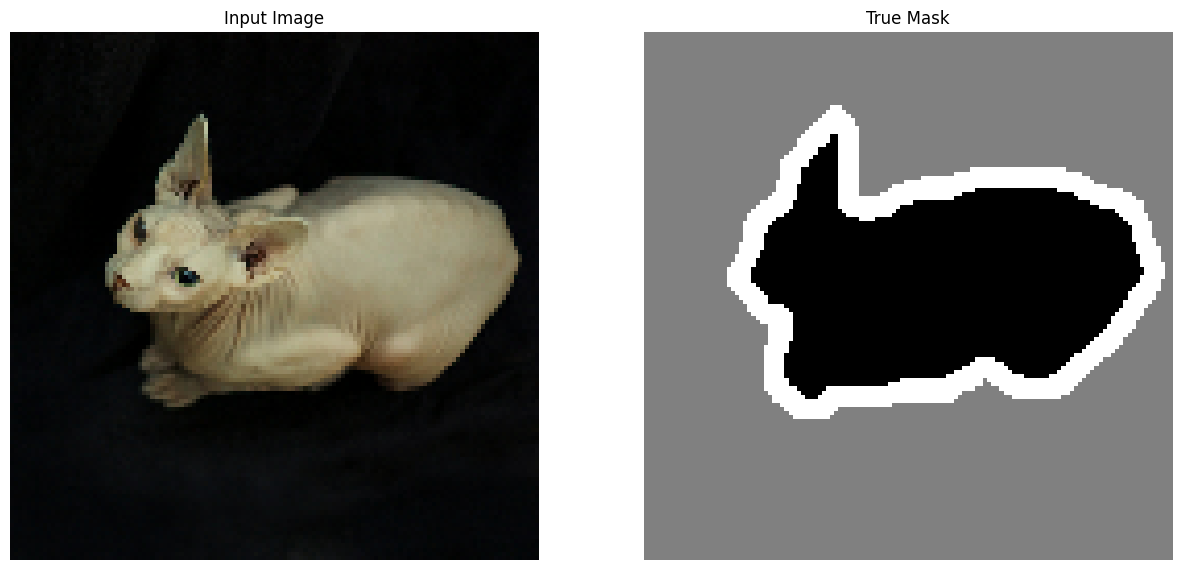

Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.5627 - loss: 0.9931 - mean_iou: 0.2455
Epoch 1: val_mean_iou improved from -inf to 0.28551, saving model to unet_oxford_pet.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 47s 527ms/step - accuracy: 0.5638 - loss: 0.9909 - mean_iou: 0.2464 - val_accuracy: 0.6392 - val_loss: 0.8300 - val_mean_iou: 0.2855
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.6930 - loss: 0.7659 - mean_iou: 0.3608
Epoch 2: val_mean_iou improved from 0.28551 to 0.35933, saving model to unet_oxford_pet.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 38s 557ms/step - accuracy: 0.6931 - loss: 0.7658 - mean_iou: 0.3609 - val_accuracy: 0.6888 - val_loss: 0.7644 - val_mean_iou: 0.3593
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.7021 - loss: 0.7439 - mean_iou: 0.3704
Epoch 3: val_mean_iou improved from 0.35933 to 0.37804, saving model to unet_oxford_pet.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 26s 463ms/step - accuracy: 0.7021 - loss: 0.7439 - mean_iou

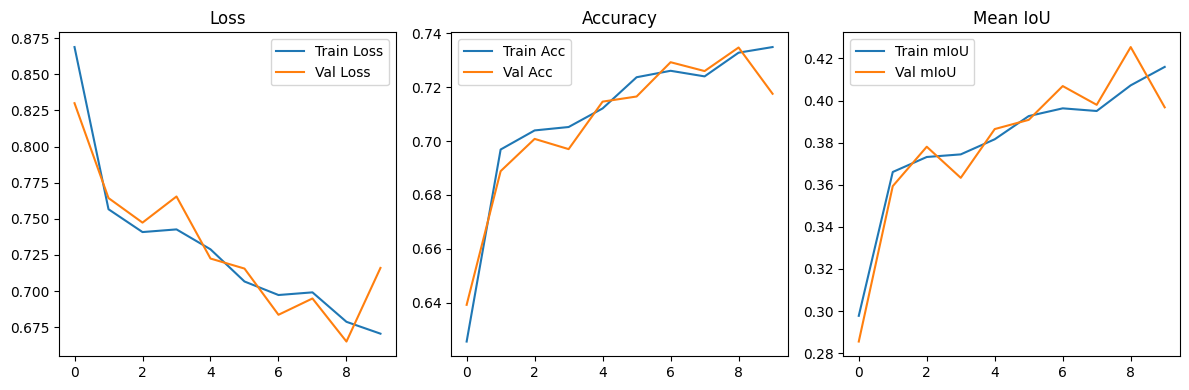

2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step


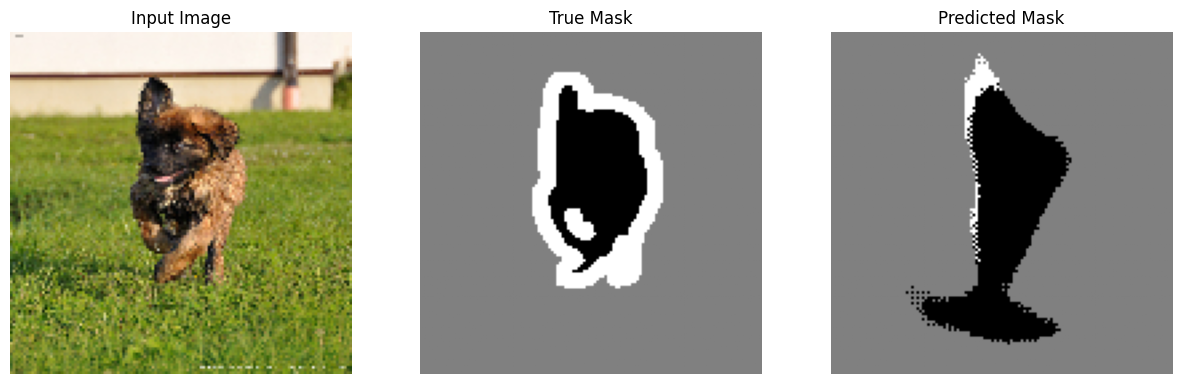

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


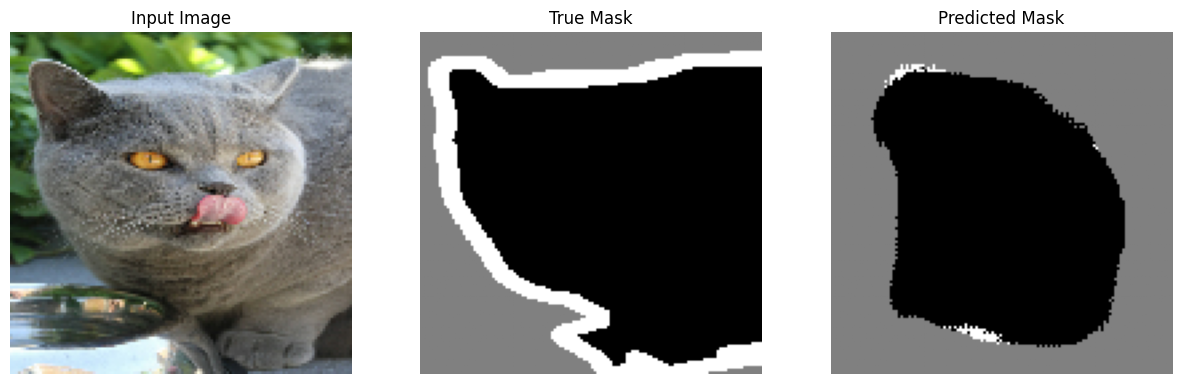

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


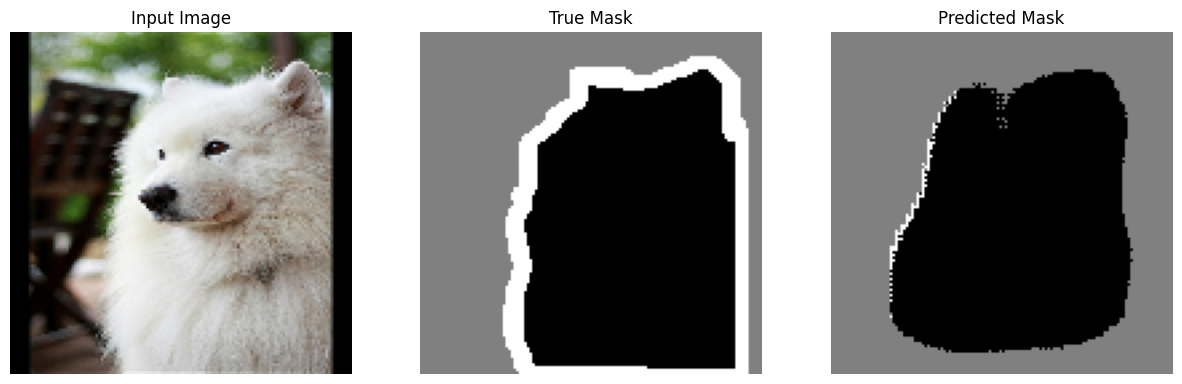

58/58 ━━━━━━━━━━━━━━━━━━━━ 29s 401ms/step - accuracy: 0.7339 - loss: 0.6673 - mean_iou: 0.4236
Test Loss: 0.6672
Test Accuracy: 0.7344
Test Mean IoU: 0.4235


In [ ]:

dataset, info = tfds.load('oxford_iiit_pet:4.0.0', with_info=True)

NUM_CLASSES = 3
IMG_SIZE = 128



train = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test  = dataset['test'].map(load_image,  num_parallel_calls=tf.data.AUTOTUNE)

TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train_dataset = (
    train
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(tf.data.AUTOTUNE)
)
test_dataset = test.batch(BATCH_SIZE)

for image, mask in train.take(1):
    display([image, mask])

model = unet_model()
checkpoint_path = "unet_oxford_pet.keras"
checkpoint = ModelCheckpoint(
    checkpoint_path, monitor='val_mean_iou', verbose=1, save_best_only=True, mode='max'
)
early_stopping = EarlyStopping(monitor='val_mean_iou', patience=10, mode='max', verbose=1)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy', mean_iou_metric]
)
EPOCHS = 10
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE // VAL_SUBSPLITS

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=test_dataset,
    validation_steps=VALIDATION_STEPS,
    callbacks=[checkpoint, early_stopping]
)


plot_history(history)

model = tf.keras.models.load_model(
    checkpoint_path,
    custom_objects={'SparseMeanIoU': SparseMeanIoU}
)


show_predictions(test_dataset, 3)

test_loss, test_acc, test_miou = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Mean IoU: {test_miou:.4f}")


model.save('unet_oxford_pet_final.keras')
